In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


# 데이터 준비와 확인

In [2]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터로더 구성


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']


def load_data(train_data, test_data, num_words=10000):
    # 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)

    # NaN 결측치 제거
    train_data = train_data.dropna(how='any')
    test_data = test_data.dropna(how='any')

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)#토큰화
        temp_X = [word for word in temp_X if not word in stopwords]#불용어 제거
        X_train.append(temp_X)
    
    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

# 모델 구성을 위한 데이터 분석 및 가공

## 시각화 하여 문장의 최대 길이를 확인해보기로 한다

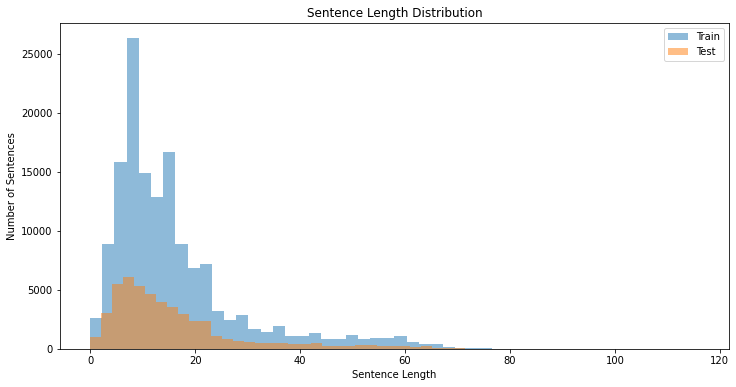

In [6]:
import matplotlib.pyplot as plt

# 각 문장의 길이를 계산
train_lengths = [len(sentence) for sentence in X_train]
test_lengths = [len(sentence) for sentence in X_test]

# 문장 길이 분포 시각화
plt.figure(figsize=(12, 6))
plt.hist(train_lengths, bins=50, alpha=0.5, label='Train')
plt.hist(test_lengths, bins=50, alpha=0.5, label='Test')
plt.title('Sentence Length Distribution')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Sentences')
plt.legend()
plt.show()

**40을 넘어서면 거의 값이 없는걸로 보여진다. 보통 문장의 95%정도를 포함한 범위로 설정한다고 하니 40정도로 설정하면 되지않을까 싶지만 자세한 값으로 표준편차를 이용해보기로한다.**

### 자세한 값도 확인해본다


In [7]:
print('train문장길이 평균 : ', np.mean(train_lengths))
print('train문장길이 최대 : ', np.max(train_lengths))
print('train문장길이 표준편차 : ', np.std(train_lengths))
print('test문장길이 평균 : ', np.mean(test_lengths))
print('test문장길이 최대 : ', np.max(test_lengths))
print('test문장길이 표준편차 : ', np.std(test_lengths))


# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens_train = np.mean(train_lengths) + 2 * np.std(train_lengths)
max_tokens_test= np.mean(test_lengths) + 2 * np.std(test_lengths)
print('max_tokens_train : ', int(max_tokens_train))
print('max_tokens_test : ', int(max_tokens_test))
max_len = int(max_tokens_train)+10
print('pad_sequences maxlen : ', max_len)
print(f'전체 문장의 {np.sum(train_lengths < max_tokens_train+10) / len(train_lengths)}%가 maxlen 설정값 이내에 포함됩니다. ')




train문장길이 평균 :  15.98170773419436
train문장길이 최대 :  116
train문장길이 표준편차 :  12.82473766384545
test문장길이 평균 :  15.932807128181134
test문장길이 최대 :  105
test문장길이 표준편차 :  12.899346084223861
max_tokens_train :  41
max_tokens_test :  41
pad_sequences maxlen :  51
전체 문장의 0.9632102447633771%가 maxlen 설정값 이내에 포함됩니다. 


**test와 train모두 표준편차가 41로 동일하다. 93퍼센트정도를 차지한다고하는데 95퍼센트를 넘기고 싶어 10의 길이를 추가해줬다**

## 이후 패딩을 진행한다.

In [8]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


# 패딩 추가
X_train_padded = pad_sequences(X_train, maxlen=max_len, padding='pre')
X_test_padded = pad_sequences(X_test, maxlen=max_len, padding='pre')

# 결과 확인
print(X_train_padded[:3])
print(X_test_padded[:3])

[[  32   74  919    4    4   39  228   20   33  748    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [1028    4   11  519  549  687    5  120    4   70 1639   52  925 1006
    15   44  391    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [  24  205    3    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]]
[[ 832  130    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0  

**그리고 pre가 더 좋다는 말에 post가 아닌pre로 지정하였다.**

# 모델 구성 및 validation set 구성

### LSTM, GRU, CNN으로 테스트를 진행
**옵티마이저는 아담으로 설정하고 LSTM과 GRU의 층은 32로 임베딩 차원은 100으로 설정했다.**

In [9]:
from sklearn.model_selection import train_test_split

# Train set과 Validation set 나누기
X_train_padded, X_val_padded, y_train, y_val = train_test_split(X_train_padded, y_train, test_size=0.2, random_state=42)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional


def create_lstm_model(vocab_size, embedding_dim, max_len):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

lstm_model = create_lstm_model(len(word_to_index), 1000, max_len)
lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 51, 1000)          9997000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               545280    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 10,542,409
Trainable params: 10,542,409
Non-trainable params: 0
_________________________________________________________________


In [16]:
from tensorflow.keras.layers import GRU

def create_gru_model(vocab_size, embedding_dim, max_len):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(Bidirectional(GRU(32)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

gru_model = create_gru_model(len(word_to_index), 1000, max_len)
gru_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 51, 1000)          9997000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                198528    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 10,195,593
Trainable params: 10,195,593
Non-trainable params: 0
_________________________________________________________________


In [17]:
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D

def create_cnn_model(vocab_size, embedding_dim, max_len):
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model(len(word_to_index), 1000, max_len)
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 51, 1000)          9997000   
_________________________________________________________________
conv1d (Conv1D)              (None, 47, 128)           640128    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 10,637,257
Trainable params: 10,637,257
Non-trainable params: 0
_________________________________________________________________


In [65]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


print("LSTM Start")
# LSTM 모델 훈련
history_lstm = lstm_model.fit(X_train_padded, y_train, epochs=10, batch_size=256, validation_data=(X_val_padded, y_val))
print("GRU Start")
# GRU 모델 훈련
history_gru = gru_model.fit(X_train_padded, y_train, epochs=10, batch_size=256, validation_data=(X_val_padded, y_val))
print("CNN Start")
# CNN 모델 훈련
history_cnn = cnn_model.fit(X_train_padded, y_train, epochs=10, batch_size=256, validation_data=(X_val_padded, y_val))

LSTM Start
Epoch 1/10
457/457 [==============================] - 13s 28ms/step - loss: 0.1021 - accuracy: 0.9608 - val_loss: 0.5983 - val_accuracy: 0.8490
Epoch 2/10
457/457 [==============================] - 13s 28ms/step - loss: 0.0816 - accuracy: 0.9694 - val_loss: 0.6309 - val_accuracy: 0.8445
Epoch 3/10
457/457 [==============================] - 13s 28ms/step - loss: 0.0642 - accuracy: 0.9762 - val_loss: 0.7069 - val_accuracy: 0.8467
Epoch 4/10
457/457 [==============================] - 13s 28ms/step - loss: 0.0503 - accuracy: 0.9816 - val_loss: 0.7625 - val_accuracy: 0.8413
Epoch 5/10
457/457 [==============================] - 13s 28ms/step - loss: 0.0419 - accuracy: 0.9851 - val_loss: 0.8314 - val_accuracy: 0.8406
Epoch 6/10
457/457 [==============================] - 13s 28ms/step - loss: 0.0380 - accuracy: 0.9864 - val_loss: 0.8363 - val_accuracy: 0.8380
Epoch 7/10
457/457 [==============================] - 13s 28ms/step - loss: 0.0363 - accuracy: 0.9870 - val_loss: 0.8842 - va

#  Loss, Accuracy 그래프 시각화

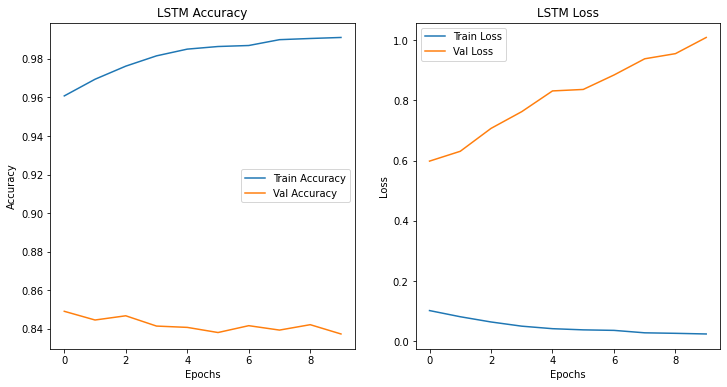

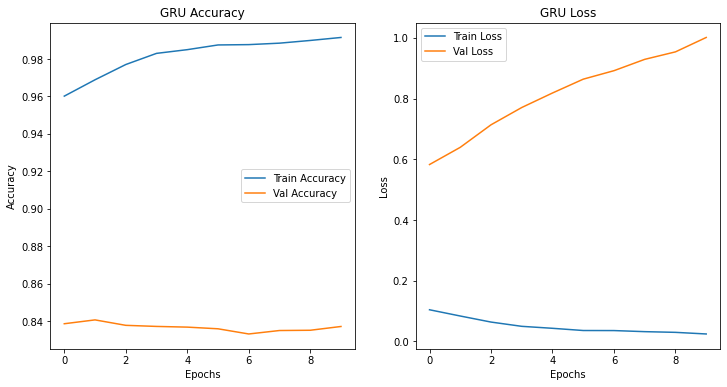

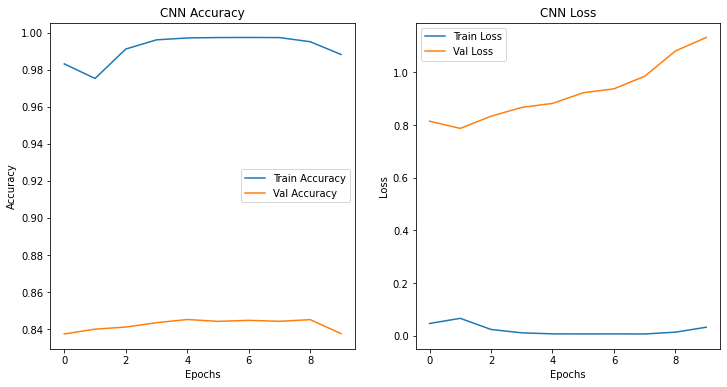

In [66]:
def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# 각 모델의 학습 결과 시각화
plot_history(history_lstm, 'LSTM')
plot_history(history_gru, 'GRU')
plot_history(history_cnn, 'CNN')

## fit(X_train_padded, y_train, epochs=10, batch_size=512, validation_data=(X_val_padded, y_val))

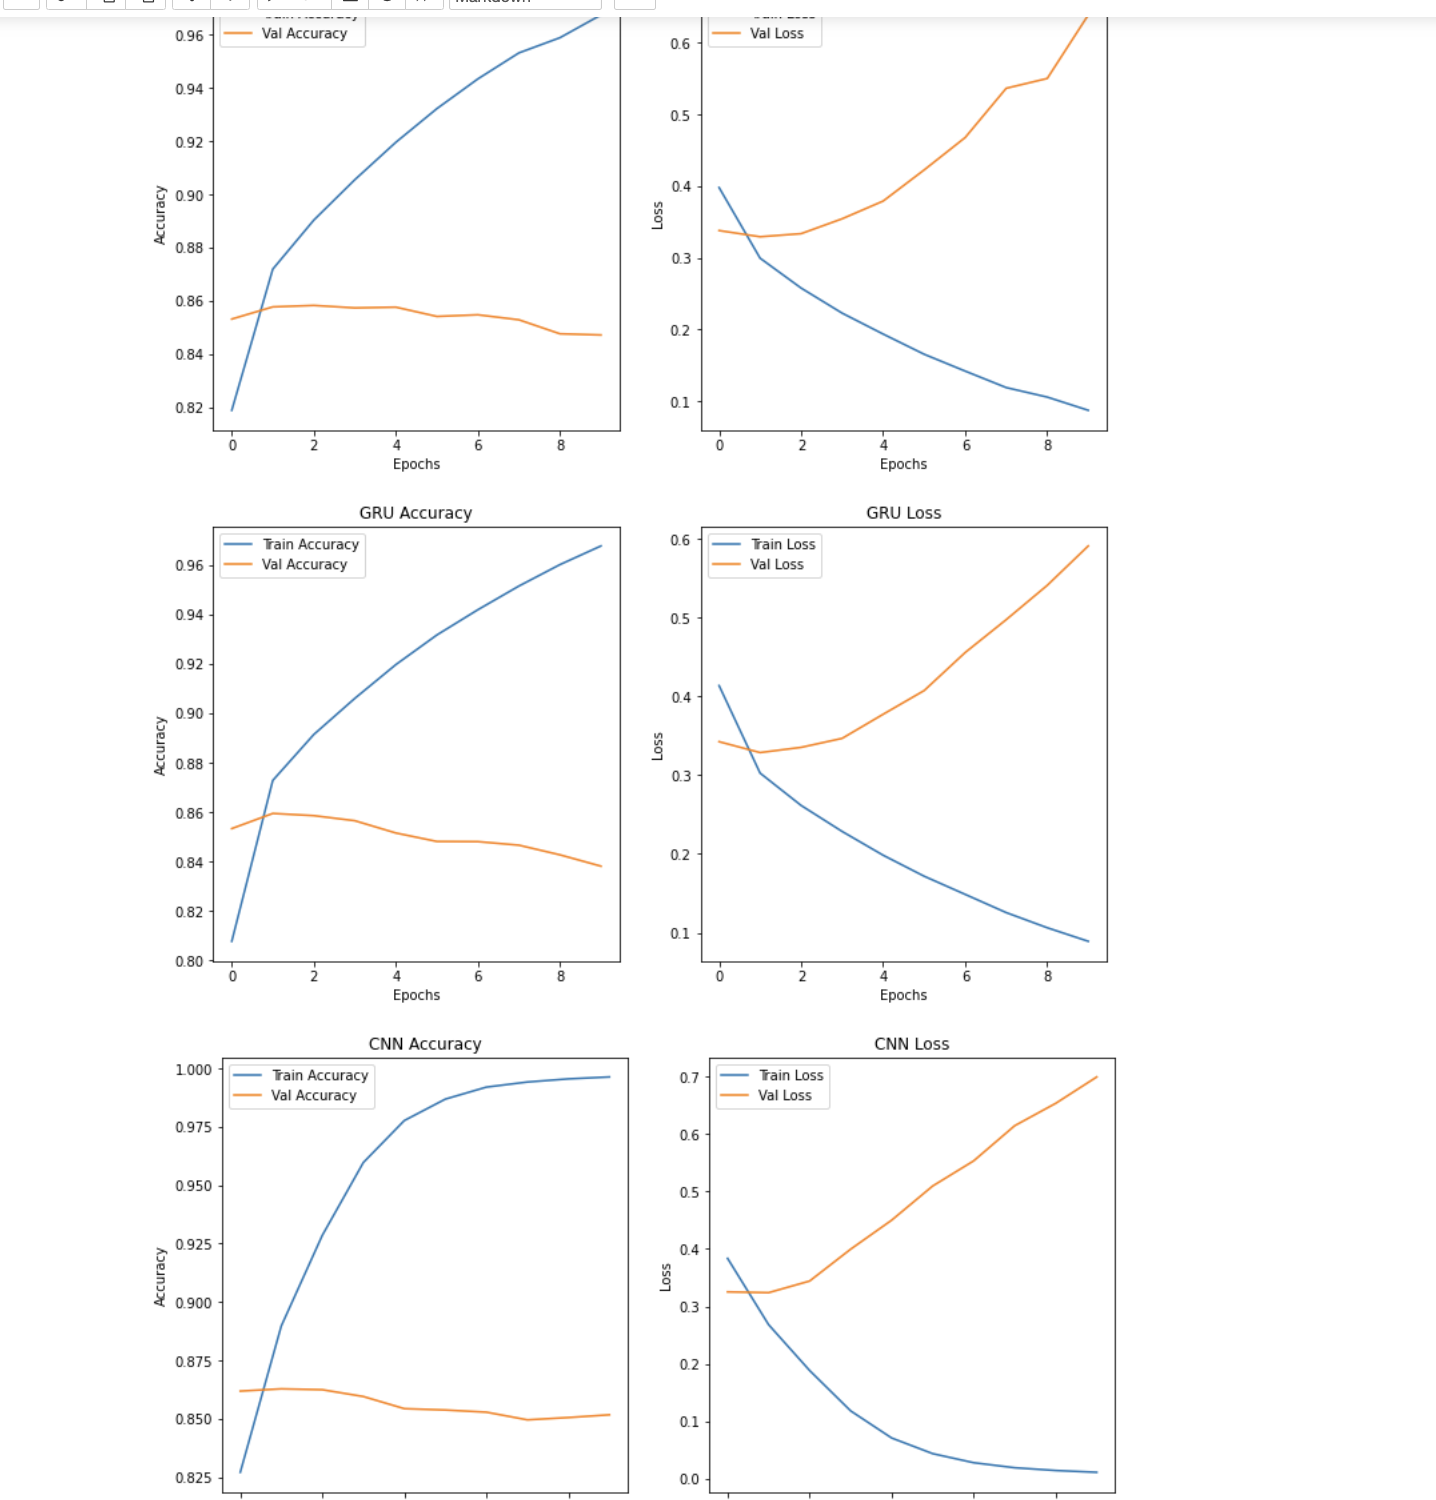

# fit(X_train_padded, y_train, epochs=10, batch_size=256, validation_data=(X_val_padded, y_val))
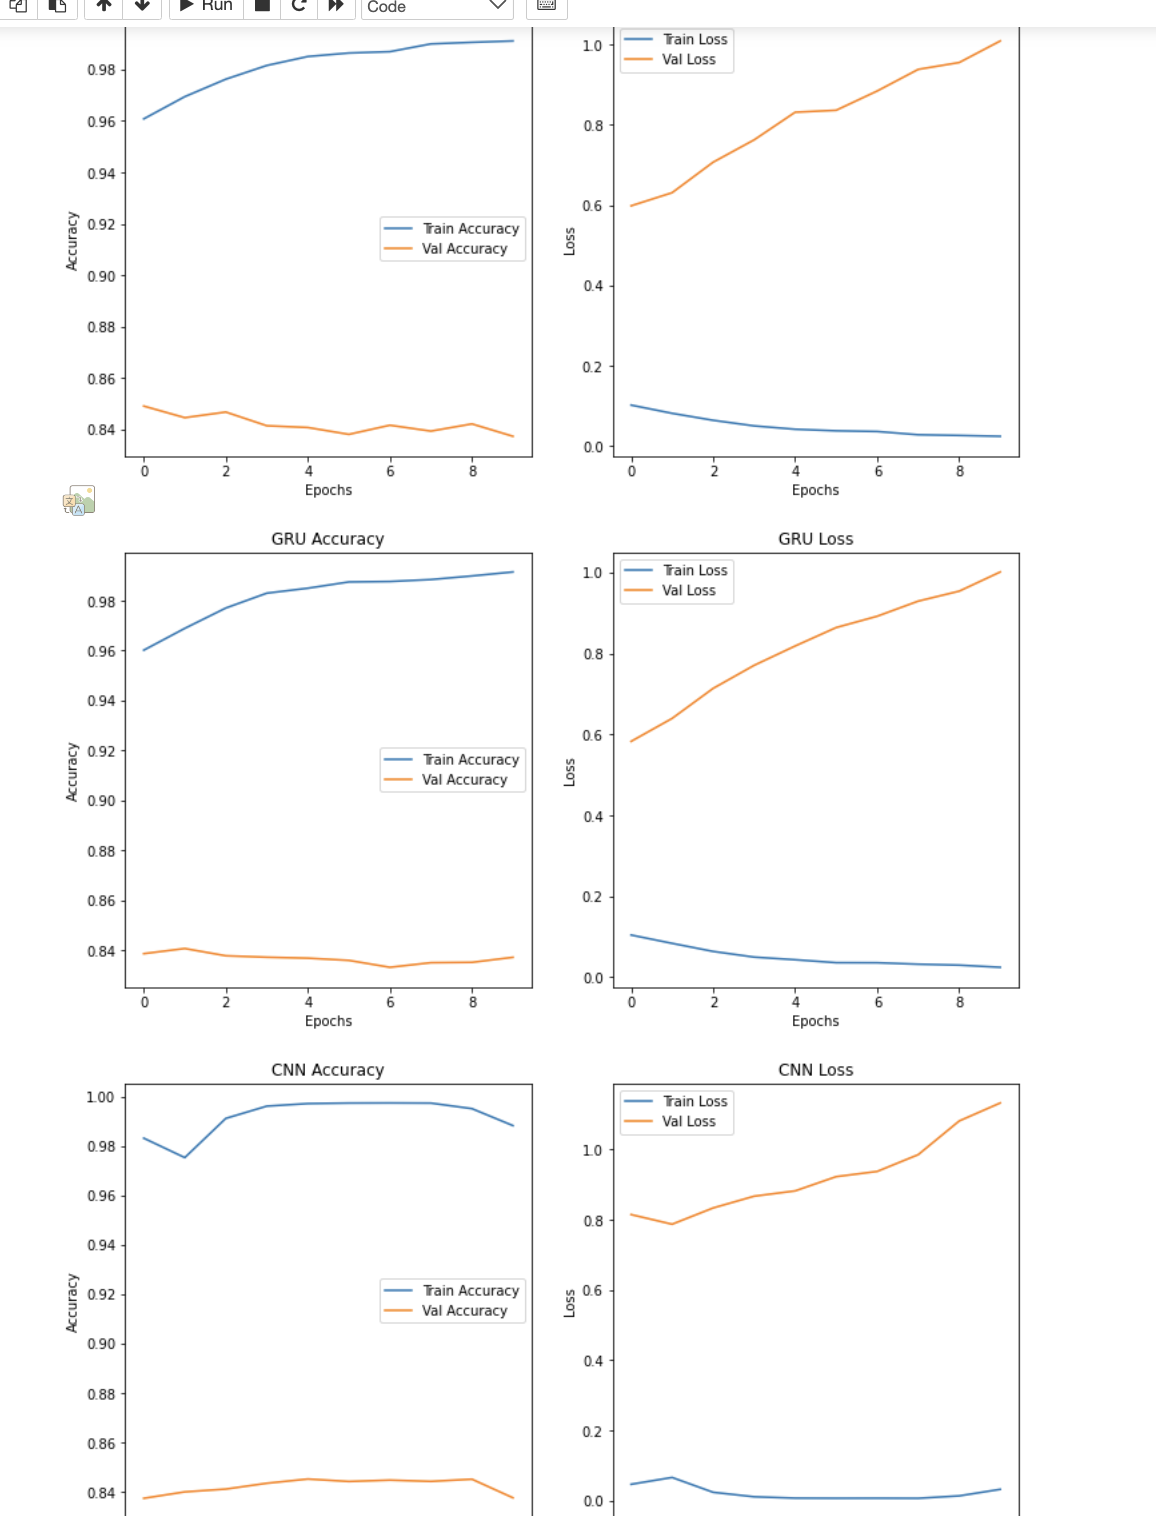
### 이미 학습을 진행한뒤 다시 진행한 부분이라 문제가 발생한듯하다.

# 학습된 Embedding 레이어 분석

In [23]:
import os
vocab_size=len(word_to_index)
word_vector_dim = 1000

embedding_layer1 = lstm_model.layers[0]
weights1 = embedding_layer1.get_weights()[0]
print(weights1.shape)

word2vec_file_path1 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_LSTM.txt'
f = open(word2vec_file_path1, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors1 = lstm_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors1[i, :])))))
f.close()


(9997, 1000)


In [25]:
embedding_layer2 = gru_model.layers[0]
weights2 = embedding_layer2.get_weights()[0]
print(weights2.shape)

word2vec_file_path2 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_GRU.txt'
f = open(word2vec_file_path2, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors2 = gru_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors2[i, :])))))
f.close()


(9997, 1000)


In [26]:
embedding_layer3 = cnn_model.layers[0]
weights3 = embedding_layer3.get_weights()[0]
print(weights3.shape)

word2vec_file_path3 = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec_CNN.txt'
f = open(word2vec_file_path3, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors3 = cnn_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors3[i, :])))))
f.close()


(9997, 1000)


## LSTM으로 학습한 임베딩

In [60]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors1 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path1, binary=False)
vector1 = word_vectors1['진짜']
vector1

array([-2.54144017e-02,  1.18543338e-02,  1.45792933e-02,  3.23200524e-02,
        2.08122246e-02, -1.97156668e-02,  5.94653562e-02, -4.25856784e-02,
        2.47525666e-02,  6.72175363e-03,  2.37121303e-02,  5.74410930e-02,
       -3.08205690e-02, -1.05522662e-01,  7.82835204e-03, -4.16513607e-02,
        3.60886082e-02,  8.57893080e-02, -4.90114652e-02,  9.72742494e-03,
       -7.93364085e-03,  1.27536282e-02,  3.63257825e-02,  3.65671813e-02,
       -5.00579327e-02, -2.41898391e-02, -1.33023979e-02,  3.15790661e-02,
       -2.25216104e-03, -3.50298770e-02,  2.14056280e-02, -7.25086331e-02,
       -6.19061068e-02, -4.11025956e-02, -4.76343185e-02,  1.16175786e-03,
       -5.61785093e-03, -2.16049775e-02, -4.18861322e-02,  2.08818018e-02,
       -4.00198204e-03,  6.02268763e-02,  7.53519079e-03,  2.55590901e-02,
       -2.15899143e-02, -1.53962495e-02,  2.47503910e-02, -7.54802302e-02,
       -1.35922115e-02, -6.11151627e-05, -6.44439310e-02,  3.00787706e-02,
       -3.84434015e-02, -

In [62]:
word_vectors1.similar_by_word("진짜")

[('밋', 0.4226236939430237),
 ('일깨워', 0.41681626439094543),
 ('넘', 0.40935662388801575),
 ('자전거', 0.407205194234848),
 ('재미있', 0.3973284065723419),
 ('건담', 0.3851492702960968),
 ('깔끔', 0.3719235360622406),
 ('꼭', 0.3707541227340698),
 ('상큼', 0.36756065487861633),
 ('울', 0.36419421434402466)]

## GRU로 학습한 임베딩


In [63]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors2 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path2, binary=False)
vector2 = word_vectors2['진짜']
vector2

array([ 1.71864517e-02,  1.17335185e-01, -1.23955421e-01, -3.25273648e-02,
       -7.39660114e-02,  3.98403555e-02, -6.12386167e-02,  6.05956987e-02,
        1.09524950e-01,  5.02356403e-02,  3.20190303e-02, -6.90398067e-02,
       -5.49746118e-02, -6.89344108e-02, -4.55614664e-02, -6.66426569e-02,
       -3.43326218e-02,  6.47521205e-03, -4.17835042e-02,  7.71442950e-02,
        3.26729380e-02,  2.87465677e-02, -7.79365748e-02, -1.09310867e-03,
       -4.71161604e-02,  7.83355832e-02,  2.19317917e-02,  6.49072677e-02,
       -6.52822480e-02, -1.38674021e-01,  4.78240475e-03, -2.95434352e-02,
        5.35234623e-02, -2.25378033e-02, -6.85319826e-02,  8.74172598e-02,
        3.78836482e-03, -1.99974831e-02,  5.84475212e-02, -1.46832196e-02,
       -4.98197153e-02, -1.04318764e-02,  7.15839341e-02,  5.12955002e-02,
       -6.21674620e-02, -3.39072011e-03, -5.24864942e-02, -4.59207259e-02,
       -6.13013050e-03, -5.42267300e-02,  5.04355617e-02,  1.96669567e-02,
       -2.08311826e-02,  

In [64]:
word_vectors2.similar_by_word("진짜")

[('역시', 0.5606945157051086),
 ('박진감', 0.5355666279792786),
 ('군요', 0.5339623093605042),
 ('계속', 0.5259562730789185),
 ('됐', 0.5216434001922607),
 ('집중', 0.5193528532981873),
 ('낭만', 0.5112451910972595),
 ('성룡', 0.5109198093414307),
 ('넘', 0.5107761025428772),
 ('^^', 0.5094962120056152)]

## CNN으로 학습한 임베딩


In [31]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors3 = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path3, binary=False)
vector3 = word_vectors3['진짜']
vector3

array([ 1.06631517e-02,  3.26304808e-02,  3.77530465e-04,  1.64900143e-02,
        7.95193017e-02, -2.10457500e-02, -3.35500017e-02,  7.12445974e-02,
        7.45320469e-02, -5.42009883e-02, -8.87032077e-02,  3.23371366e-02,
        4.68631238e-02,  1.07378840e-01, -2.22565769e-03,  1.37700979e-02,
       -9.09259766e-02,  4.38781679e-02,  6.50513312e-03, -1.14820644e-01,
        3.91665287e-02, -5.38398437e-02,  7.65847787e-03,  3.67785580e-02,
        5.43960137e-03,  1.33299187e-01,  2.28684749e-02,  4.43625776e-03,
        6.22158609e-02, -4.70159650e-02,  6.19495250e-02, -6.04281165e-02,
       -6.74340799e-02,  7.91425109e-02,  7.32803643e-02,  3.02444361e-02,
        5.34487702e-03, -2.65135448e-02,  4.14886288e-02,  7.49663189e-02,
        2.73356605e-02,  5.18197101e-03, -2.94411704e-02, -7.72339525e-03,
        2.35312036e-03,  6.91226050e-02,  1.09645799e-02, -4.88862507e-02,
       -2.74848705e-03, -4.29789722e-02, -4.35329080e-02, -3.18209007e-02,
       -9.63294283e-02, -

In [34]:
word_vectors3.similar_by_word("정말로")

[('너무나', 0.33815544843673706),
 ('클로이', 0.28765520453453064),
 ('완전', 0.25339725613594055),
 ('시놉시스', 0.24979828298091888),
 ('전지현', 0.24503061175346375),
 ('근본', 0.24337361752986908),
 ('하나님', 0.23948322236537933),
 ('마술', 0.22934654355049133),
 ('겁나', 0.22924105823040009),
 ('도시', 0.2279030829668045)]

# 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [48]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = '/aiffel/data/word2vec_ko.model'  # 모델 경로
word_vectors1 = Word2VecKeyedVectors.load(word2vec_file_path)
vector1 = word_vectors1.wv['정말로']
vector1

array([ 1.6519084 , -0.52489007, -1.3256671 , -0.50195616,  0.03030834,
       -1.0502422 , -0.23948689,  0.13218822,  0.03410624,  0.974712  ,
       -1.7840528 , -0.22761624, -0.27150026,  0.41189024, -0.14554237,
        0.81591195, -0.02378765, -0.809412  ,  1.8431813 , -2.1785502 ,
       -0.91967905,  0.39355978,  1.5870951 , -0.7018544 , -0.93284476,
        0.9289666 ,  0.43955678,  1.1554443 ,  1.2419893 ,  0.03355711,
       -0.3527967 , -0.67629766, -0.74433154,  0.48760617,  0.6876957 ,
       -0.11309965, -1.6172816 ,  0.24381682, -0.76720846,  0.23646289,
        0.02434174,  0.04615156, -0.06464554,  0.20495562, -0.794897  ,
       -0.1626733 ,  0.31635943, -1.3953997 ,  0.49058536, -0.8049499 ,
       -1.6481302 ,  0.11834961,  0.3849262 ,  0.41098514, -0.70570475,
       -0.7353042 ,  0.5788185 , -1.4658217 , -0.03805516, -0.67443544,
       -0.19193356, -0.25033706, -0.86123616, -1.258291  ,  1.0818769 ,
       -1.5573277 , -1.072012  ,  0.3199295 , -0.9077153 ,  0.33

In [54]:
word_vectors1.wv.similar_by_word("하나님")

[('하느님', 0.9558471441268921),
 ('그리스도', 0.8831457495689392),
 ('성령', 0.8630900979042053),
 ('그분', 0.847241997718811),
 ('말씀', 0.8182541131973267),
 ('예수', 0.8066360354423523),
 ('야훼', 0.8012031316757202),
 ('은총', 0.7909775972366333),
 ('계시', 0.7840383648872375),
 ('창조주', 0.757165789604187)]

In [55]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = '/aiffel/data/word2vec_ko.model'  # 모델 경로
word_vectors2 = Word2VecKeyedVectors.load(word2vec_file_path)
vector2 = word_vectors2.wv['하나님']
vector2

array([ 4.424972  , -1.971676  , -3.3577693 ,  0.985919  , -1.6239744 ,
       -3.701571  ,  4.8051662 , -3.1997917 , -0.37655666, -0.95965284,
       -1.1711895 ,  1.123477  , -2.4759579 ,  1.1924347 , -2.345002  ,
        1.015524  , -2.585604  , -1.2525524 ,  3.5076997 , -2.5298846 ,
       -3.7462316 , -0.6417846 , -0.94271237,  0.9382616 ,  1.9743015 ,
        2.236961  ,  2.4468725 ,  0.30499706,  0.18259983, -3.6559672 ,
       -1.1647131 ,  0.20886527, -3.8981009 ,  2.6076565 ,  1.011704  ,
        2.0507267 ,  1.1329024 ,  1.8271    ,  0.874468  ,  1.2998832 ,
       -1.1326108 ,  2.040514  ,  4.219015  ,  0.6020559 ,  1.860111  ,
        3.649302  ,  5.095837  ,  2.808689  , -1.7316184 ,  4.1809816 ,
       -1.380046  ,  2.3663368 ,  3.5156748 , -3.7773178 ,  1.6736954 ,
       -5.5935736 , -2.167975  ,  0.94765586, -0.47240534,  1.3327729 ,
        3.5992503 ,  0.78246355, -0.16258036, -3.5805469 ,  1.3015387 ,
       -4.9470925 , -1.2008098 , -1.2960266 , -0.8302401 , -1.26

In [56]:
word_vectors2.wv.similar_by_word("하나님")

[('하느님', 0.9558471441268921),
 ('그리스도', 0.8831457495689392),
 ('성령', 0.8630900979042053),
 ('그분', 0.847241997718811),
 ('말씀', 0.8182541131973267),
 ('예수', 0.8066360354423523),
 ('야훼', 0.8012031316757202),
 ('은총', 0.7909775972366333),
 ('계시', 0.7840383648872375),
 ('창조주', 0.757165789604187)]

In [57]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = '/aiffel/data/word2vec_ko.model'  # 모델 경로
word_vectors3 = Word2VecKeyedVectors.load(word2vec_file_path)
vector3 = word_vectors3.wv['하나님']
vector3

array([ 4.424972  , -1.971676  , -3.3577693 ,  0.985919  , -1.6239744 ,
       -3.701571  ,  4.8051662 , -3.1997917 , -0.37655666, -0.95965284,
       -1.1711895 ,  1.123477  , -2.4759579 ,  1.1924347 , -2.345002  ,
        1.015524  , -2.585604  , -1.2525524 ,  3.5076997 , -2.5298846 ,
       -3.7462316 , -0.6417846 , -0.94271237,  0.9382616 ,  1.9743015 ,
        2.236961  ,  2.4468725 ,  0.30499706,  0.18259983, -3.6559672 ,
       -1.1647131 ,  0.20886527, -3.8981009 ,  2.6076565 ,  1.011704  ,
        2.0507267 ,  1.1329024 ,  1.8271    ,  0.874468  ,  1.2998832 ,
       -1.1326108 ,  2.040514  ,  4.219015  ,  0.6020559 ,  1.860111  ,
        3.649302  ,  5.095837  ,  2.808689  , -1.7316184 ,  4.1809816 ,
       -1.380046  ,  2.3663368 ,  3.5156748 , -3.7773178 ,  1.6736954 ,
       -5.5935736 , -2.167975  ,  0.94765586, -0.47240534,  1.3327729 ,
        3.5992503 ,  0.78246355, -0.16258036, -3.5805469 ,  1.3015387 ,
       -4.9470925 , -1.2008098 , -1.2960266 , -0.8302401 , -1.26

In [58]:
word_vectors3.wv.similar_by_word("하나님")

[('하느님', 0.9558471441268921),
 ('그리스도', 0.8831457495689392),
 ('성령', 0.8630900979042053),
 ('그분', 0.847241997718811),
 ('말씀', 0.8182541131973267),
 ('예수', 0.8066360354423523),
 ('야훼', 0.8012031316757202),
 ('은총', 0.7909775972366333),
 ('계시', 0.7840383648872375),
 ('창조주', 0.757165789604187)]

# 회고

- 배운 점 : RNN을 제대로 처음 다뤄본것같다. 온전히 내께 된것같지는 않지만 그래도 어떤 흐름으로 진행되고 어떻게 사용하는지 정도는 배운것 같다.

- 아쉬운 점 : Word2VecKeyedVectors 를 적용하는데 생각보다 시간을 많이 사용해 다양한 값으로 테스트를 진행하지 못한것이 조금 아쉽습니다.

- 느낀 점 : 역시 기존에 학습된 모델이 성능이 우월하다...

- 어려웠던 점 : 제공되어 있는 코드를 변환해 작업한 결과 크게 어려움은 느끼지 못했지만, 초반부분에 word_to_index에 있는 패딩을 어떻게 해야할지 찾는데 조금 오래 걸렸습니다. 결국 그냥 설정을 안해도 자동으로 패딩되는걸 찾아 따로 설정하지않고 진행했습니다.